In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import multivariate_normal
from plot_utils import plotContourNormal, Dirichlet, draw_pdf_contours, \
                       plotContourTruncatedNormal
import seaborn as sns
import tensorflow as tf
from efn_util import setup_IO, find_convergence, model_opt_hps
from tf_util.stat_util import drawPoissonCounts
from plot_util import exptrend, sattrend, load_V1_events, \
                      find_last_ind, get_latest_diagnostics
import scipy.io as sio
from tf_util.families import family_from_str

import os

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

exp_fam = 'lgc';
D = 20;

wsize = 50;
delta_thresh = 1e-10;

basedir = '/Users/sbittner/Documents/efn/';
dir_str = exp_fam;

fam_class = family_from_str(exp_fam);
family = fam_class(D);

T_s = .02;
K = 100;
M = 200;
TIF_flow_type = 'PlanarFlowLayer'; 
nlayers = 30;
flow_dict = {'latent_dynamics':None, \
             'scale_layer':False, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};
param_net_hps = {'L':5};
give_hint = False;
rs = 0;

In [3]:
def easy_inds():
    num_monkeys = 3;
    num_neurons = [83, 59, 105]
    num_oris = 12;
    N = int(sum(num_neurons*num_oris));
    monkeys = np.zeros((N,));
    neurons = np.zeros((N,));
    oris = np.zeros((N,));

    ind = 0;
    for i in range(num_monkeys):
        monkey = i+1;
        nneurons = num_neurons[i];
        for j in range(nneurons):
            neuron = j+1;
            for k in range(num_oris):
                ori = k+1;
                monkeys[ind] = monkey;
                neurons[ind] = neuron;
                oris[ind] = ori;
                ind += 1;
    return monkeys, neurons, oris;


def load_counts_spikes(monkey, neuron, ori):
    # get counts
    respdir = '/Users/sbittner/Documents/efn/data/responses/';
    fname = respdir + 'spike_counts_monkey%d_neuron%d_ori%d.mat' % (monkey, neuron, ori);
    M = sio.loadmat(fname);
    counts = M['x'];
    
     # get spikes
    SNR_thresh = 1.5;
    FR_thresh = 1.0;
    events = load_V1_events(monkey, SNR_thresh, FR_thresh);
    spikes = events[neuron-1, ori-1,:];
    return counts, spikes;

def cut_trailing_spikes(events, D, T_s):
    ntrials = events.shape[0];
    spikes = [];
    t_end = D*T_s;
    for i in range(ntrials):
        _event_i = events[i];
        _event_i = [0.0] + _event_i[_event_i < t_end].tolist();
        spikes.append(_event_i);
    return spikes
    

def time_series_contour(Z, prctiles, T_s):
    num_prctiles = len(prctiles);
    is_odd = np.mod(num_prctiles,2)==1;
    if (not is_odd):
        print('Error: use odd number of symmetric percentiles');
        return None;
    mid_prctile_ind = num_prctiles // 2;
        
    
    T = Z.shape[1];
    zs = np.zeros((num_prctiles,T));
    for i in range(num_prctiles):
        for t in range(T):
            zs[i,t] = np.percentile(Z[:,t], prctiles[i]);
    

    t = np.linspace(0,(T-1)*T_s, T) + (T_s/2.0);
    for i in range(num_prctiles):
        if (i == mid_prctile_ind):
            plt.plot(t,zs[i], 'k');
        else:
            plt.plot(t,zs[i], 'k--');
    return None;

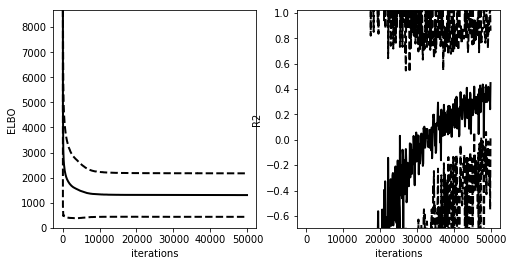

In [4]:
prctiles = [5, 25, 50, 75, 95];
monkey_by_ind, neuron_by_ind, ori_by_ind = easy_inds();
efn_savedir = basedir + setup_IO(family, 'EFN', dir_str, 'eta', K, M, flow_dict, param_net_hps, \
                                             give_hint, rs);
npzfile = np.load(efn_savedir + 'results.npz');

check_rate = npzfile['check_rate'];
test_elbos = npzfile['test_elbos'];
mean_elbos = np.mean(test_elbos, 1);
std_elbos = np.std(test_elbos, 1);

test_R2s = npzfile['train_R2s'];
mean_R2s = np.mean(test_R2s, 1);
std_R2s = np.std(test_R2s, 1);

last_ind = find_last_ind(test_elbos);
#final_ind = find_convergence(mean_elbos, last_ind+1, wsize, delta_thresh);
#if (final_ind is None):
#    print('didnt converge');
#    final_ind = last_ind;
final_ind = 500;
its = np.arange(0, check_rate*final_ind, check_rate);

plt.figure(figsize=(8, 4));
plt.subplot(1,2,1);
plt.plot(its, mean_elbos[:final_ind], 'k', lw=2);
min_val = np.min(mean_elbos[:final_ind]-std_elbos[:final_ind]);
plt.plot(its, mean_elbos[:final_ind]+std_elbos[:final_ind],'k--', lw=2);
plt.plot(its, mean_elbos[:final_ind]-std_elbos[:final_ind],'k--', lw=2);
std_mag = std_elbos[final_ind];
min_val = np.min(mean_elbos);
max_val = min_val + 10*std_mag;
plt.ylim([min_val, max_val]);
plt.xlabel('iterations');
plt.ylabel('ELBO');

plt.subplot(1,2,2);
plt.plot(its, mean_R2s[:final_ind], 'k', lw=2);
min_val = np.min(mean_R2s[:final_ind]-std_R2s[:final_ind]);
plt.plot(its, mean_R2s[:final_ind]+std_R2s[:final_ind],'k--', lw=2);
plt.plot(its, mean_R2s[:final_ind]-std_R2s[:final_ind],'k--', lw=2);
std_mag = std_R2s[final_ind];
max_val = np.max(mean_R2s) + std_mag;
min_val = max_val - 4*std_mag;
plt.ylim([min_val, max_val]);
plt.xlabel('iterations');
plt.ylabel('R2');

plt.show()

In [5]:
model_str_prefix = 'NF1_log_gaussian_cox_D=20_flow=30P'
lgcdir = '/Users/sbittner/Documents/efn/results/lgc/';
dir_list = os.listdir(lgcdir);
num_dir_elems = len(dir_list);
num_models = 0;
model_strs = [];
nits = 0;
for i in range(num_dir_elems):
    model_str_i = dir_list[i];
    if (model_str_prefix in model_str_i):
        model_strs.append(model_str_i)
        fname_i = lgcdir + model_str_i + '/results.npz'
        npzfile = np.load(fname_i);
        train_elbos = npzfile['train_elbos'];
        nits_i = train_elbos.shape[0];
        if (nits_i > nits):
            nits = nits_i;
        num_models += 1;

        
final_ind = 500;

all_train_elbos = np.zeros((num_models, final_ind))
for i in range(num_models):
    fname_i = lgcdir + model_strs[i] + '/results.npz'
    npzfile = np.load(fname_i);
    all_train_elbos[i,:] = npzfile['train_elbos'][:final_ind,0];


In [6]:
mean_train_elbos = np.mean(all_train_elbos, 0);
std_train_elbos = np.std(all_train_elbos, 0);
its = np.arange(0, final_ind*check_rate, check_rate);


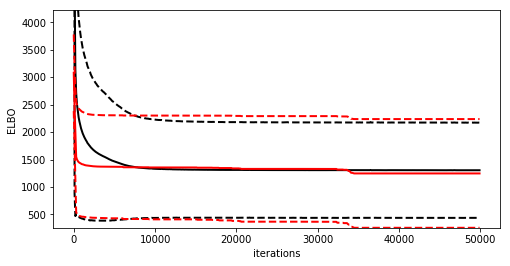

In [7]:
plt.figure(figsize=(8, 4));
plt.plot(its, mean_elbos[:final_ind], 'k', lw=2);
min_val = np.min(mean_elbos[:final_ind]-std_elbos[:final_ind]);
plt.plot(its, mean_elbos[:final_ind]+std_elbos[:final_ind],'k--', lw=2);
plt.plot(its, mean_elbos[:final_ind]-std_elbos[:final_ind],'k--', lw=2);

plt.plot(its, mean_train_elbos[:final_ind], 'r', lw=2);
min_val = np.min(mean_train_elbos[:final_ind]-std_train_elbos[:final_ind]);
plt.plot(its, mean_train_elbos[:final_ind]+std_train_elbos[:final_ind],'r--', lw=2);
plt.plot(its, mean_train_elbos[:final_ind]-std_train_elbos[:final_ind],'r--', lw=2);
std_mag = std_train_elbos[final_ind-1];
min_val = np.min(mean_train_elbos) - std_mag
max_val = min_val + 4*std_mag;
plt.ylim([min_val, max_val]);
plt.xlabel('iterations');
plt.ylabel('ELBO');

In [8]:
mean_efn_elbos = mean_elbos;
mean_nf_elbos = mean_train_elbos;

In [14]:
efn_lgc_dir = '/Users/sbittner/Documents/efn/results/lgc/EFN_log_gaussian_cox_D=20_K=100_M=200_flow=30P_L=5_rs=0/';
npzfile = np.load(efn_lgc_dir + 'profile.npz');
efn_avgtime = np.mean(npzfile['times'][-10:]);

nf_lgc_dir = '/Users/sbittner/Documents/efn/results/lgc/NF1_log_gaussian_cox_D=20_flow=30P_ds=0_rs=0/';
npzfile = np.load(nf_lgc_dir + 'profile.npz');
nf_avgtime = np.mean(npzfile['times'][-10:]);

print('EFN average it', efn_avgtime);
print('NF1 average it', nf_avgtime)

EFN average it 0.1036653995513916
NF1 average it 0.03385097980499267


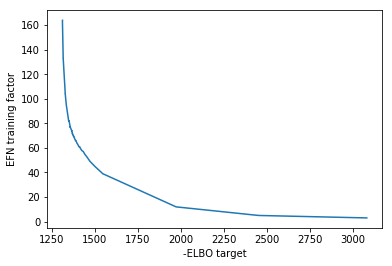

In [16]:
nits = 500;
its = np.arange(nits);
efn_better_its = np.zeros((nits,));
for i in range(nits):
    efn_better_it = np.where(mean_efn_elbos[:final_ind] < mean_nf_elbos[i])[0];
    if (len(efn_better_it) > 0):
        efn_better_its[i] = efn_better_it[0]
    else:
        efn_better_its[i] = np.nan;
plt.figure();
plt.plot(mean_nf_elbos, efn_better_its);
plt.xlabel('-ELBO target');
plt.ylabel('EFN training factor');
plt.show();
    